In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import tensorflow as tf

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from mlxtend.classifier import StackingClassifier
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scikeras.wrappers import KerasClassifier
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.layers import LSTM, Dense, Dropout, Embedding
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

EDA

In [88]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

#Load dataset
df = pd.read_csv('call_transcript_cleaned.csv')
print(df.head)

<bound method NDFrame.head of      CONVERSATION_ID  CONVERSATION_STEP  \
0                  6                  2   
1                  6                  3   
2                  6                  4   
3                  6                  5   
4                  6                  6   
..               ...                ...   
353               28                  7   
354               28                  8   
355               27                  2   
356               27                  3   
357               51                 10   

                                                  TEXT  \
0    Hello, my name is Jamie. I'm interested in vol...   
1    Yes, I'm really passionate about environmental...   
2    Great, how do I sign up, and where can I find ...   
3    Could you send me the link, please? And my ema...   
4    Thank you so much for your help. I'm really lo...   
..                                                 ...   
353  You're making a big mistake by delaying. Y

In [89]:
print(df.shape)
print(df.describe(exclude='number'))

(358, 7)
                                                     TEXT  \
count                                                 358   
unique                                                349   
top     You're making this more difficult than it need...   
freq                                                    3   

                                                  CONTEXT LABEL FEATURES  
count                                                 358   358      358  
unique                                                321     7      291  
top     Scammer pressures for immediate financial acti...  scam  unknown  
freq                                                    5   189       21  


In [90]:
label_counts = df['LABEL'].value_counts()
context_counts = df['CONTEXT'].value_counts()
features_counts = df['FEATURES'].value_counts()
missing_values = df.isnull().sum()

print("\nValue Counts in LABEL:\n", label_counts)
print("\nValue Counts in CONTEXT (Top 5):\n", context_counts.head())
print("\nValue Counts in FEATURES (Top 5):\n", features_counts.head())
print("\nMissing Values by Column:\n", missing_values)


Value Counts in LABEL:
 LABEL
scam                   189
neutral                 98
legitimate              29
suspicious              26
potential_scam           7
slightly_suspicious      6
highly_suspicious        3
Name: count, dtype: int64

Value Counts in CONTEXT (Top 5):
 CONTEXT
Scammer pressures for immediate financial action, bypassing verification”        5
Scammer dismisses the request for supervisor contact, citing immediate risk.”    3
Positive closure                                                                 3
Claims urgent bill payment needed                                                3
Introduction of a potential technical support scam                               3
Name: count, dtype: int64

Value Counts in FEATURES (Top 5):
 FEATURES
unknown                      21
verification_request         17
urgency, guilt_inducement     6
urgency, deflects             5
positive_closure              4
Name: count, dtype: int64

Missing Values by Column:
 CONVERSATIO

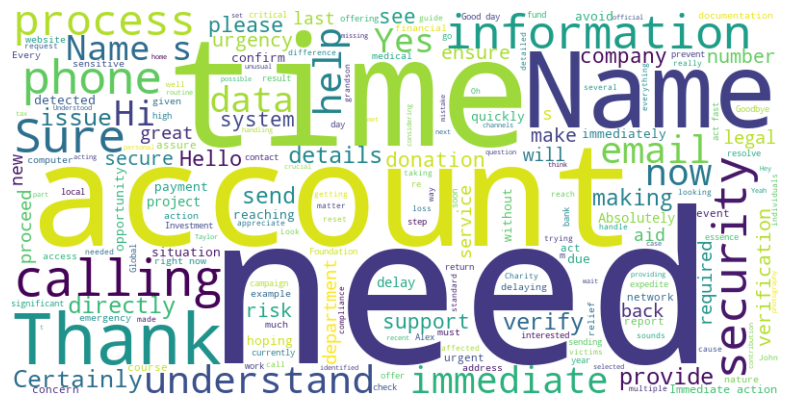

In [91]:
text_data = " ".join(df['TEXT'].dropna())  # Make sure to drop any NaN values

# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=200, 
    contour_color='steelblue'
).generate(text_data)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off the axis
plt.show()

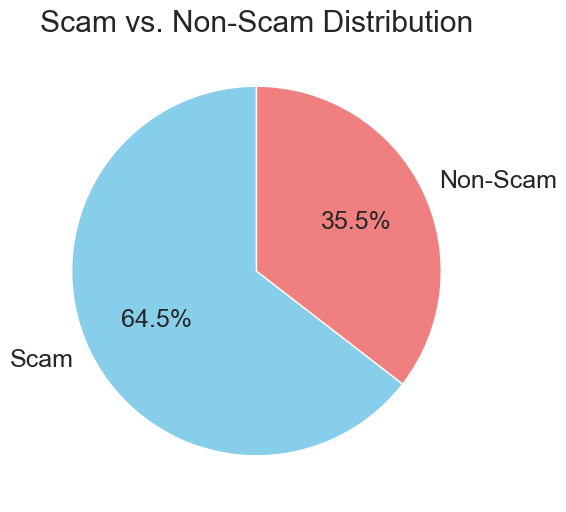

In [92]:
# Count the occurrences of each category
category_counts = df['CATEGORY'].value_counts()

# Map numeric labels to descriptive labels
labels = ['Non-Scam' if cat == 0 else 'Scam' for cat in category_counts.index]

# Create a pie chart
plt.figure(figsize=(6, 6))  # Optional: Adjust figure size
plt.pie(
    category_counts, 
    labels=labels, 
    autopct='%1.1f%%',  # Display percentages with one decimal place
    startangle=90,  # Start the chart at 90 degrees
    colors=['skyblue', 'lightcoral']  # Optional: Add custom colors
)
plt.title("Scam vs. Non-Scam Distribution")
plt.show()

In [93]:
# Checking character count
df['Length'] = df['TEXT'].str.len()
df.head(10)

,CONVERSATION_ID,CONVERSATION_STEP,TEXT,CONTEXT,LABEL,FEATURES,CATEGORY,Length
0,6,2,"Hello, my name is Jamie. I'm interested in vol...",Encourages the caller's interest,neutral,"welcoming, positive_tone",0,58
1,6,3,"Yes, I'm really passionate about environmental...",Reinforces anyone can volunteer,neutral,inclusive,0,62
2,6,4,"Great, how do I sign up, and where can I find ...",Demonstrates flexibility,neutral,"helpful_tone, offers_options",0,65
3,6,5,"Could you send me the link, please? And my ema...",Fulfills caller's request quickly,neutral,prompt_action,0,76
4,6,6,Thank you so much for your help. I'm really lo...,"Positive closure, offers future help",neutral,"supportive, positive_tone",0,73
5,2,2,"Yes, hello, this is John Smith calling from th...","Potential scam, no initial relationship",neutral,verification_request,0,226
6,2,3,Certainly. The issue pertains to unreported in...,Requesting specifics,suspicious,"evasive, urgency",1,173
7,2,4,Due to the sensitive nature of the matter and ...,Refusing standard verification,suspicious,"evasion, authority_figure, urgency",1,182
8,2,5,"I'm the assigned case manager, and I can assur...",Insisting on verification,highly_suspicious,"threat, urgency",1,164
9,2,6,...failure to comply could result in immediate...,Classic scam tactic,neutral,unknown,0,62


In [94]:
# Checking character count
def word_count(review):
    review_list = review.split()
    return len(review_list)
df['Word_count'] = df['TEXT'].apply(word_count)
df.head(10)

,CONVERSATION_ID,CONVERSATION_STEP,TEXT,CONTEXT,LABEL,FEATURES,CATEGORY,Length,Word_count
0,6,2,"Hello, my name is Jamie. I'm interested in vol...",Encourages the caller's interest,neutral,"welcoming, positive_tone",0,58,9
1,6,3,"Yes, I'm really passionate about environmental...",Reinforces anyone can volunteer,neutral,inclusive,0,62,7
2,6,4,"Great, how do I sign up, and where can I find ...",Demonstrates flexibility,neutral,"helpful_tone, offers_options",0,65,13
3,6,5,"Could you send me the link, please? And my ema...",Fulfills caller's request quickly,neutral,prompt_action,0,76,12
4,6,6,Thank you so much for your help. I'm really lo...,"Positive closure, offers future help",neutral,"supportive, positive_tone",0,73,14
5,2,2,"Yes, hello, this is John Smith calling from th...","Potential scam, no initial relationship",neutral,verification_request,0,226,34
6,2,3,Certainly. The issue pertains to unreported in...,Requesting specifics,suspicious,"evasive, urgency",1,173,27
7,2,4,Due to the sensitive nature of the matter and ...,Refusing standard verification,suspicious,"evasion, authority_figure, urgency",1,182,27
8,2,5,"I'm the assigned case manager, and I can assur...",Insisting on verification,highly_suspicious,"threat, urgency",1,164,29
9,2,6,...failure to comply could result in immediate...,Classic scam tactic,neutral,unknown,0,62,9


In [95]:
# Checking mean word length
df['mean_word_length'] = df['TEXT'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
df.head(10)

,CONVERSATION_ID,CONVERSATION_STEP,TEXT,CONTEXT,LABEL,FEATURES,CATEGORY,Length,Word_count,mean_word_length
0,6,2,"Hello, my name is Jamie. I'm interested in vol...",Encourages the caller's interest,neutral,"welcoming, positive_tone",0,58,9,5.555556
1,6,3,"Yes, I'm really passionate about environmental...",Reinforces anyone can volunteer,neutral,inclusive,0,62,7,8.000000
2,6,4,"Great, how do I sign up, and where can I find ...",Demonstrates flexibility,neutral,"helpful_tone, offers_options",0,65,13,4.076923
3,6,5,"Could you send me the link, please? And my ema...",Fulfills caller's request quickly,neutral,prompt_action,0,76,12,5.416667
4,6,6,Thank you so much for your help. I'm really lo...,"Positive closure, offers future help",neutral,"supportive, positive_tone",0,73,14,4.285714
5,2,2,"Yes, hello, this is John Smith calling from th...","Potential scam, no initial relationship",neutral,verification_request,0,226,34,5.676471
6,2,3,Certainly. The issue pertains to unreported in...,Requesting specifics,suspicious,"evasive, urgency",1,173,27,5.444444
7,2,4,Due to the sensitive nature of the matter and ...,Refusing standard verification,suspicious,"evasion, authority_figure, urgency",1,182,27,5.777778
8,2,5,"I'm the assigned case manager, and I can assur...",Insisting on verification,highly_suspicious,"threat, urgency",1,164,29,4.689655
9,2,6,...failure to comply could result in immediate...,Classic scam tactic,neutral,unknown,0,62,9,6.000000


In [96]:
# Checking mean sentence length
df['mean_sent_length'] = df['TEXT'].map(
    lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)])
    )
df.head(10)

,CONVERSATION_ID,CONVERSATION_STEP,TEXT,CONTEXT,LABEL,FEATURES,CATEGORY,Length,Word_count,mean_word_length,mean_sent_length
0,6,2,"Hello, my name is Jamie. I'm interested in vol...",Encourages the caller's interest,neutral,"welcoming, positive_tone",0,58,9,5.555556,28.5
1,6,3,"Yes, I'm really passionate about environmental...",Reinforces anyone can volunteer,neutral,inclusive,0,62,7,8.000000,62.0
2,6,4,"Great, how do I sign up, and where can I find ...",Demonstrates flexibility,neutral,"helpful_tone, offers_options",0,65,13,4.076923,65.0
3,6,5,"Could you send me the link, please? And my ema...",Fulfills caller's request quickly,neutral,prompt_action,0,76,12,5.416667,37.5
4,6,6,Thank you so much for your help. I'm really lo...,"Positive closure, offers future help",neutral,"supportive, positive_tone",0,73,14,4.285714,36.0
5,2,2,"Yes, hello, this is John Smith calling from th...","Potential scam, no initial relationship",neutral,verification_request,0,226,34,5.676471,112.5
6,2,3,Certainly. The issue pertains to unreported in...,Requesting specifics,suspicious,"evasive, urgency",1,173,27,5.444444,86.0
7,2,4,Due to the sensitive nature of the matter and ...,Refusing standard verification,suspicious,"evasion, authority_figure, urgency",1,182,27,5.777778,90.5
8,2,5,"I'm the assigned case manager, and I can assur...",Insisting on verification,highly_suspicious,"threat, urgency",1,164,29,4.689655,81.5
9,2,6,...failure to comply could result in immediate...,Classic scam tactic,neutral,unknown,0,62,9,6.000000,62.0


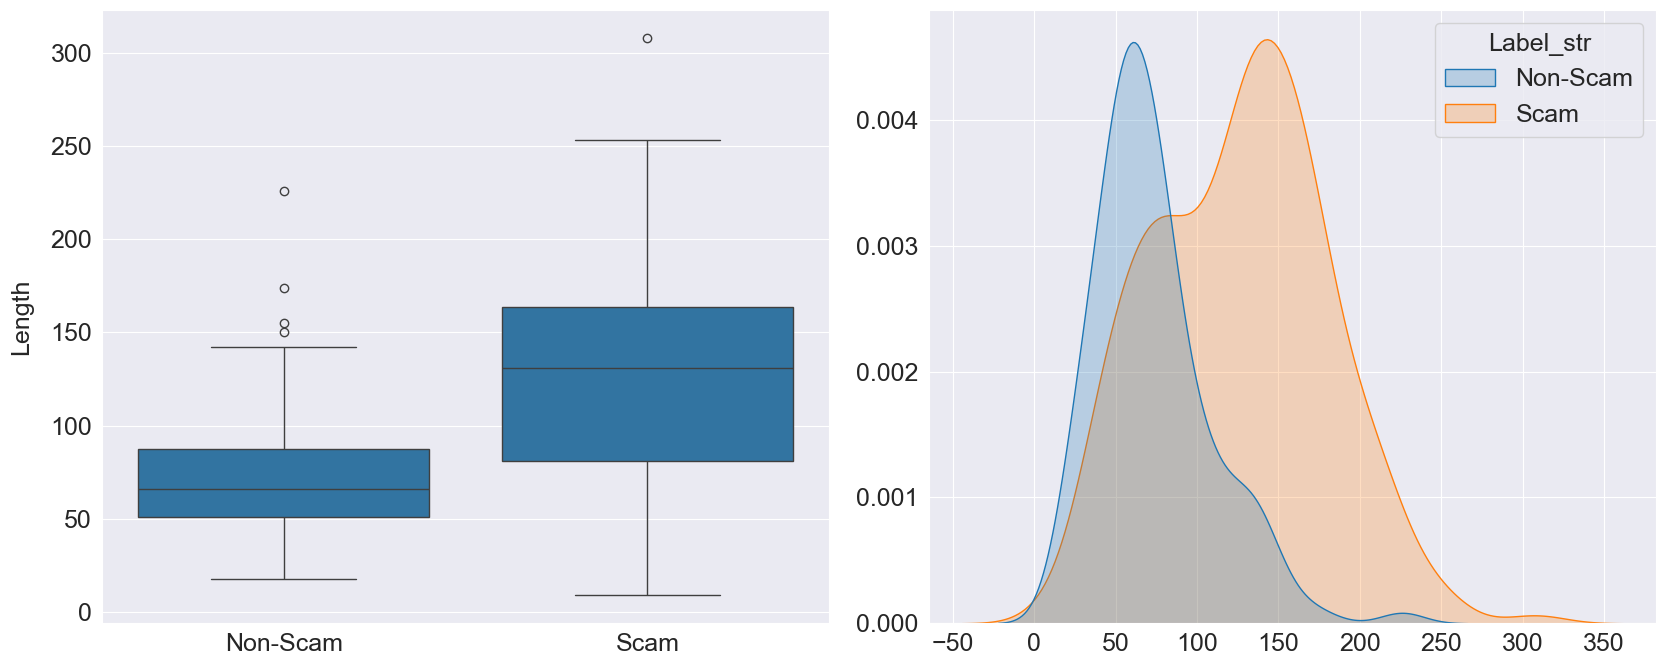

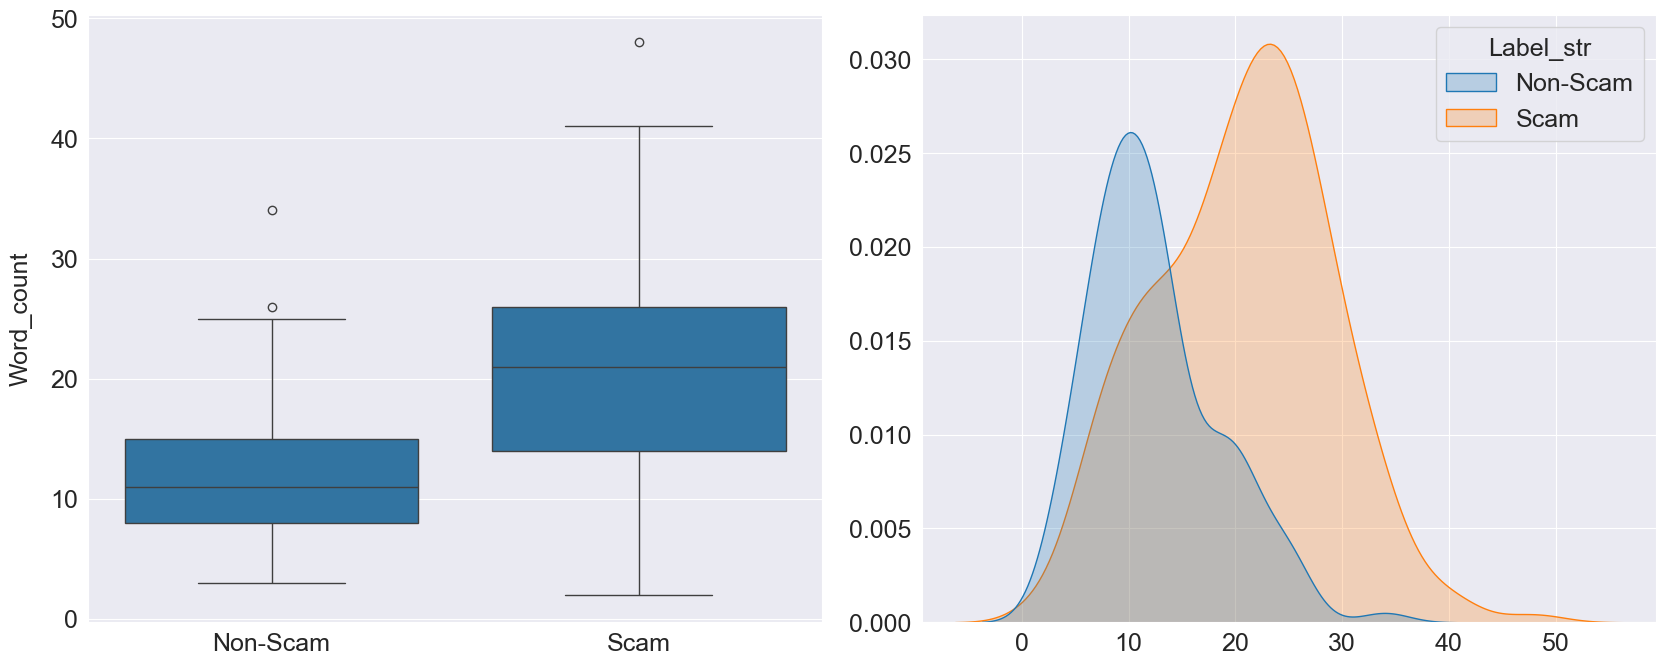

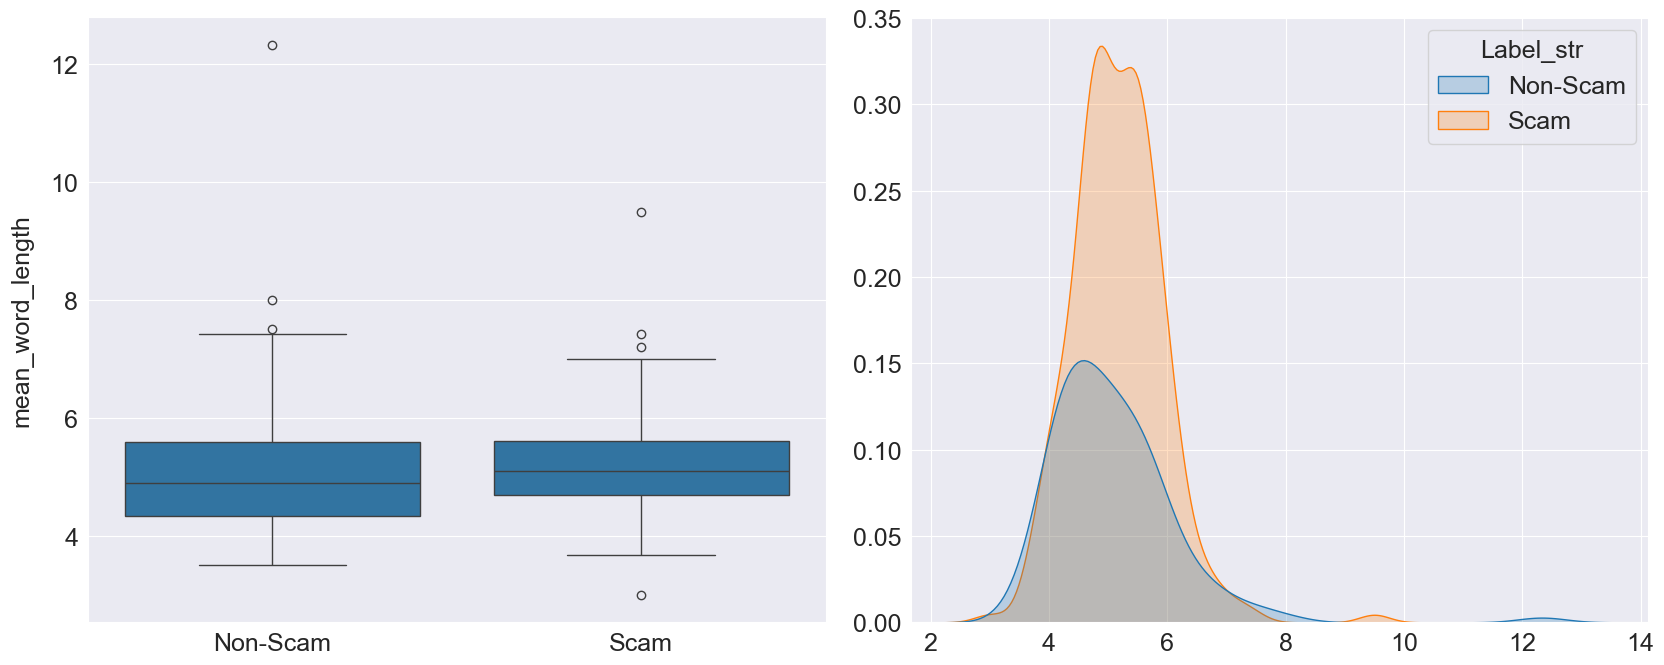

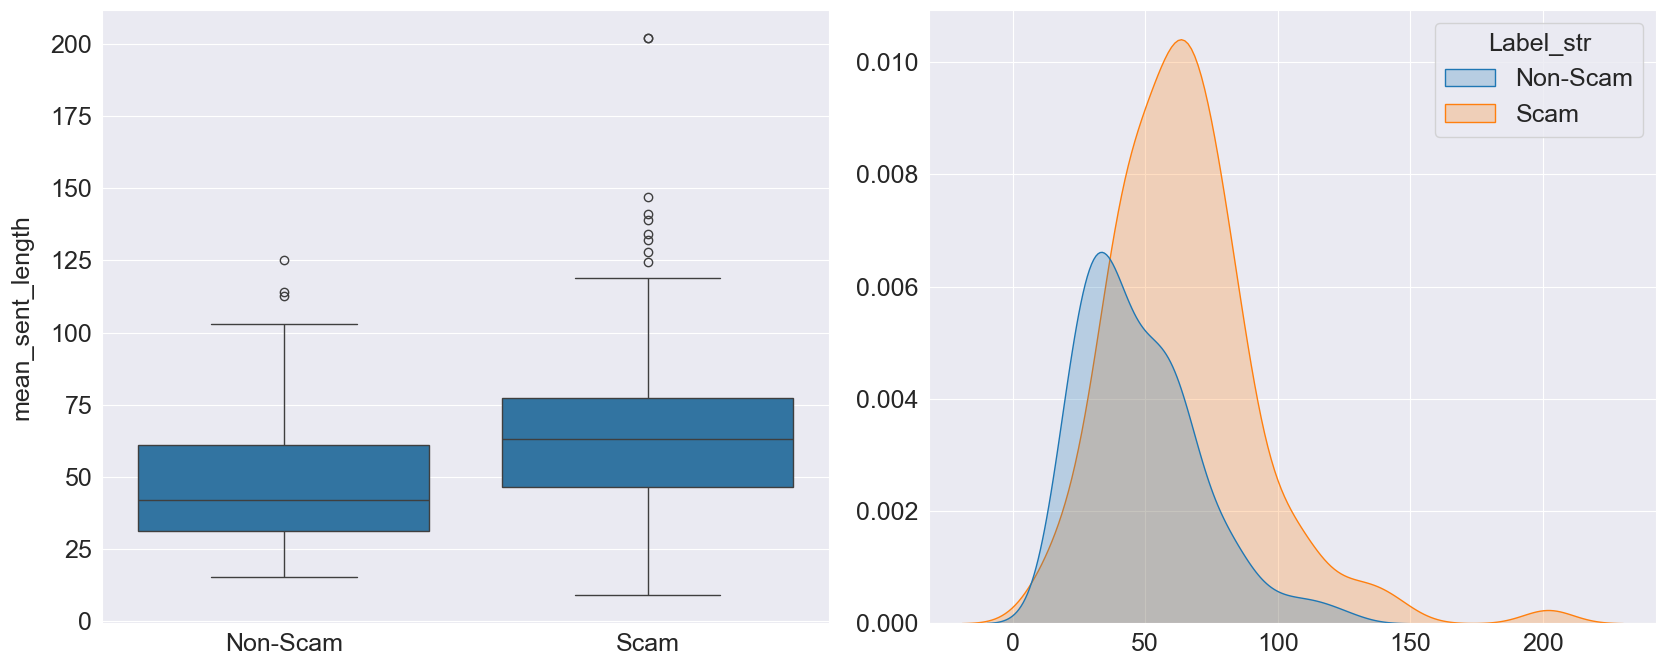

In [97]:
# Map numerical labels to string labels
df['Label_str'] = df['CATEGORY'].map({0: 'Non-Scam', 1: 'Scam'})

def visualize(col):
    print()
    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df['Label_str'], y=df[col])
    plt.ylabel(col, labelpad=12.5)
    plt.xlabel('')  # Optional: Remove the x-axis label for cleaner appearance
    
    # KDE plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=col, hue='Label_str', fill=True)
    plt.xlabel('')  # Optional: Remove the x-axis label for cleaner appearance
    plt.ylabel('')  # Optional: Remove the y-axis label for cleaner appearance
    
    plt.tight_layout()
    plt.show()

features = ['Length', 'Word_count', 'mean_word_length', 'mean_sent_length']
for feature in features:
    visualize(feature)

In [98]:
def clean(text):
    
    text = text.lower()
    text = re.sub('[^a-z A-Z 0-9-]+', '', text)
    text = " ".join([word for word in text.split() if word not in stopwords.words('english')])
    
    return text

df['TEXT'] = df['TEXT'].apply(clean)
df = df.sort_values(by=["CONVERSATION_ID", "CONVERSATION_STEP"], ascending=[True, True])

df.head(10)

,CONVERSATION_ID,CONVERSATION_STEP,TEXT,CONTEXT,LABEL,FEATURES,CATEGORY,Length,Word_count,mean_word_length,mean_sent_length,Label_str
17,0,2,hi im sam saw ad photography workshop hosted n...,Assistant is open and encouraging,neutral,informative,0,142,26,4.500000,46.666667,Non-Scam
18,0,3,thanks wondering skill level required particip...,Addresses the concern directly,neutral,helpful_tone,0,103,16,5.500000,33.666667,Non-Scam
19,0,4,sounds perfect whats registration process,Offers assistance options,neutral,informative,0,53,7,6.714286,26.000000,Non-Scam
20,0,5,direct link would great also tell workshop fee,Proactive in facilitating registration,neutral,unknown,0,74,15,4.000000,36.500000,Non-Scam
21,0,6,sure samphotographyexamplecom,"Confirms information, offers further help",neutral,unknown,0,39,3,12.333333,39.000000,Non-Scam
22,0,7,thats everything thanks help,Positive closure,neutral,unknown,0,44,7,5.428571,21.500000,Non-Scam
12,1,2,hey alex hoping catch name since last spoke,Verifying relationship (standard security),neutral,verification_request,0,97,20,3.900000,31.666667,Non-Scam
13,1,3,oh go way back met college friends since wante...,Asking for personal detail,slightly_suspicious,personal_detail,1,101,21,3.857143,33.000000,Scam
14,1,4,yeah goes jay among friends weve plenty advent...,Call appears legitimate,neutral,unknown,0,85,15,4.733333,42.000000,Non-Scam
15,1,5,appreciate thanks,Gathering call context,legitimate,unknown,0,24,4,5.250000,24.000000,Non-Scam


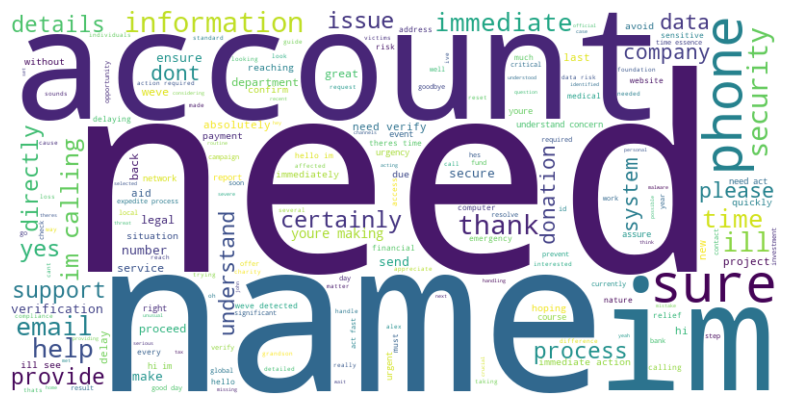

In [99]:
# Concatenate all text entries into a single string
text_data = " ".join(df['TEXT'].dropna())  # Make sure to drop any NaN values

# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=200, 
    contour_color='steelblue'
).generate(text_data)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off the axis
plt.show()

In [100]:
def corpus(text):
    text_list = text.split()
    return text_list
df['Text_lists'] = df['TEXT'].apply(corpus)
df.head(10)

,CONVERSATION_ID,CONVERSATION_STEP,TEXT,CONTEXT,LABEL,FEATURES,CATEGORY,Length,Word_count,mean_word_length,mean_sent_length,Label_str,Text_lists
17,0,2,hi im sam saw ad photography workshop hosted n...,Assistant is open and encouraging,neutral,informative,0,142,26,4.500000,46.666667,Non-Scam,"[hi, im, sam, saw, ad, photography, workshop, ..."
18,0,3,thanks wondering skill level required particip...,Addresses the concern directly,neutral,helpful_tone,0,103,16,5.500000,33.666667,Non-Scam,"[thanks, wondering, skill, level, required, pa..."
19,0,4,sounds perfect whats registration process,Offers assistance options,neutral,informative,0,53,7,6.714286,26.000000,Non-Scam,"[sounds, perfect, whats, registration, process]"
20,0,5,direct link would great also tell workshop fee,Proactive in facilitating registration,neutral,unknown,0,74,15,4.000000,36.500000,Non-Scam,"[direct, link, would, great, also, tell, works..."
21,0,6,sure samphotographyexamplecom,"Confirms information, offers further help",neutral,unknown,0,39,3,12.333333,39.000000,Non-Scam,"[sure, samphotographyexamplecom]"
22,0,7,thats everything thanks help,Positive closure,neutral,unknown,0,44,7,5.428571,21.500000,Non-Scam,"[thats, everything, thanks, help]"
12,1,2,hey alex hoping catch name since last spoke,Verifying relationship (standard security),neutral,verification_request,0,97,20,3.900000,31.666667,Non-Scam,"[hey, alex, hoping, catch, name, since, last, ..."
13,1,3,oh go way back met college friends since wante...,Asking for personal detail,slightly_suspicious,personal_detail,1,101,21,3.857143,33.000000,Scam,"[oh, go, way, back, met, college, friends, sin..."
14,1,4,yeah goes jay among friends weve plenty advent...,Call appears legitimate,neutral,unknown,0,85,15,4.733333,42.000000,Non-Scam,"[yeah, goes, jay, among, friends, weve, plenty..."
15,1,5,appreciate thanks,Gathering call context,legitimate,unknown,0,24,4,5.250000,24.000000,Non-Scam,"[appreciate, thanks]"


In [101]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['Text_lists'][i]
len(corpus)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 358/358 [00:00<00:00, 35171.12it/s]


3540

In [102]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('im', 68),
 ('need', 66),
 ('could', 39),
 ('immediate', 33),
 ('ill', 31),
 ('time', 29),
 ('name', 26),
 ('calling', 26),
 ('information', 24),
 ('phone', 24)]

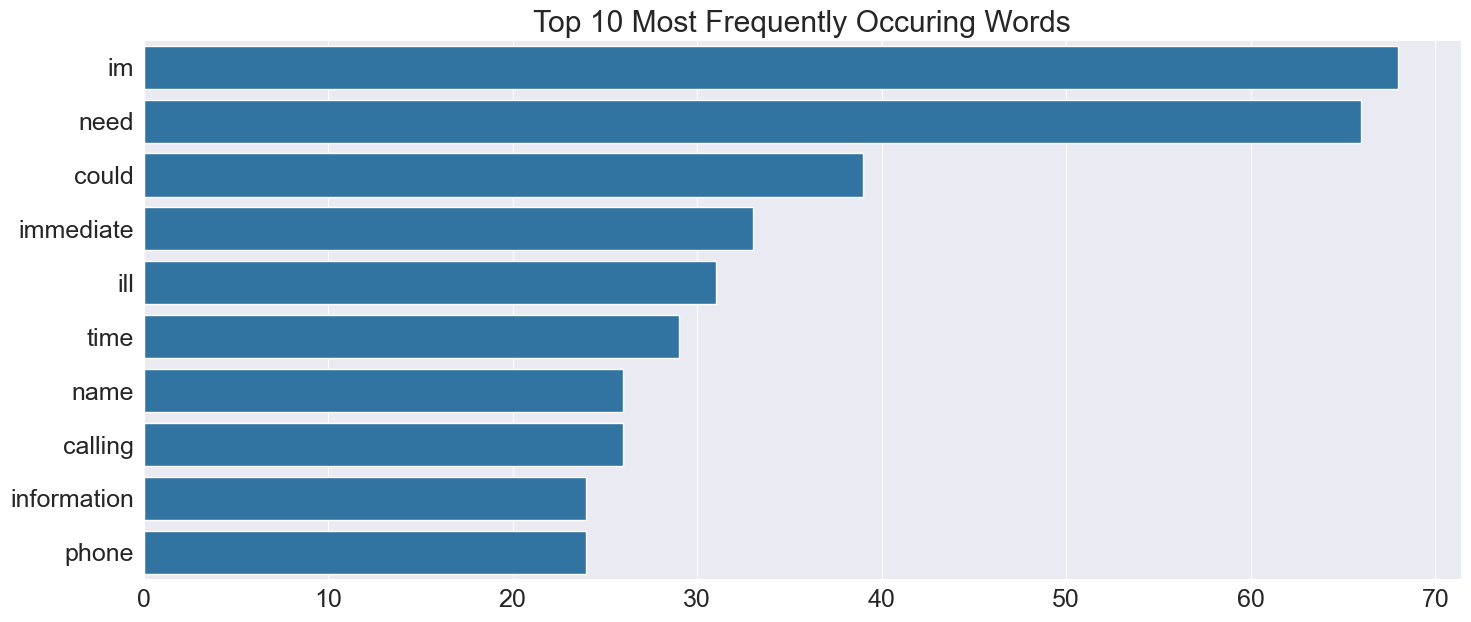

In [103]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)
    
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

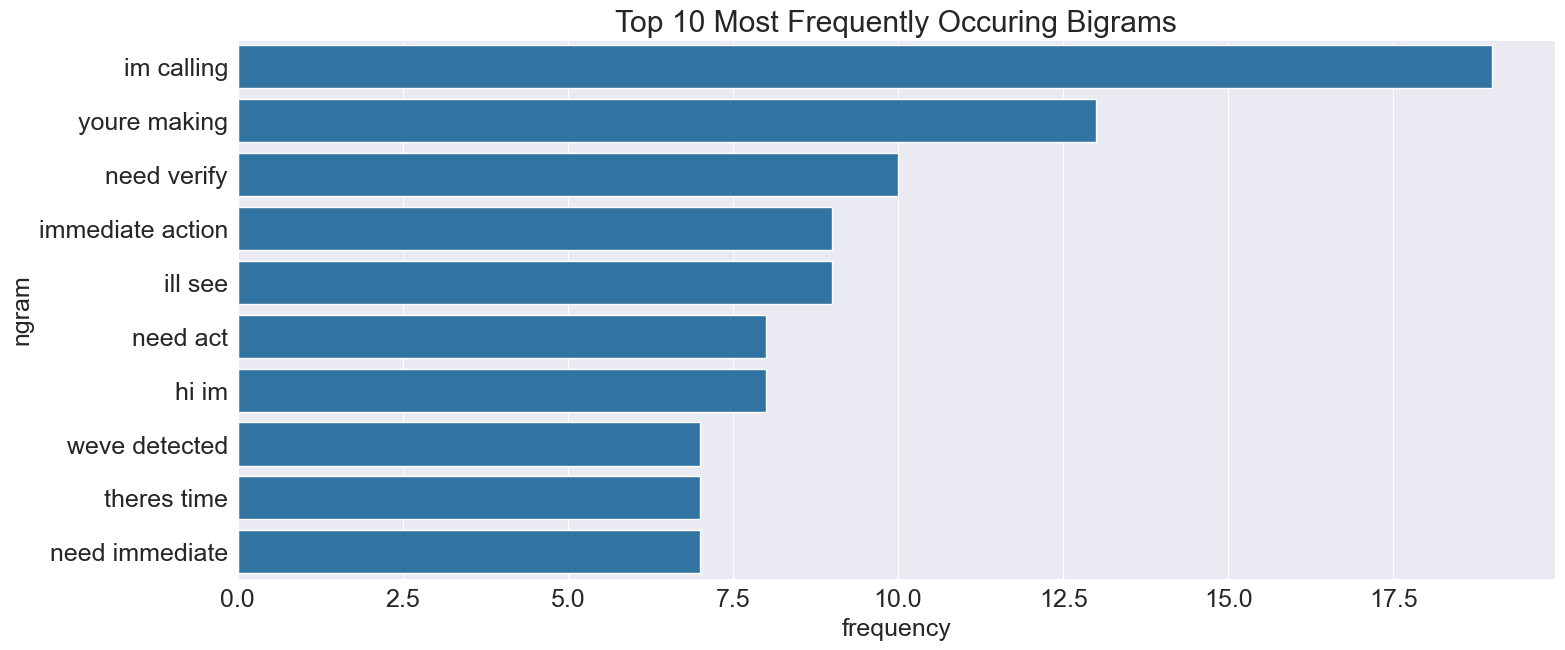

In [104]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['TEXT'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

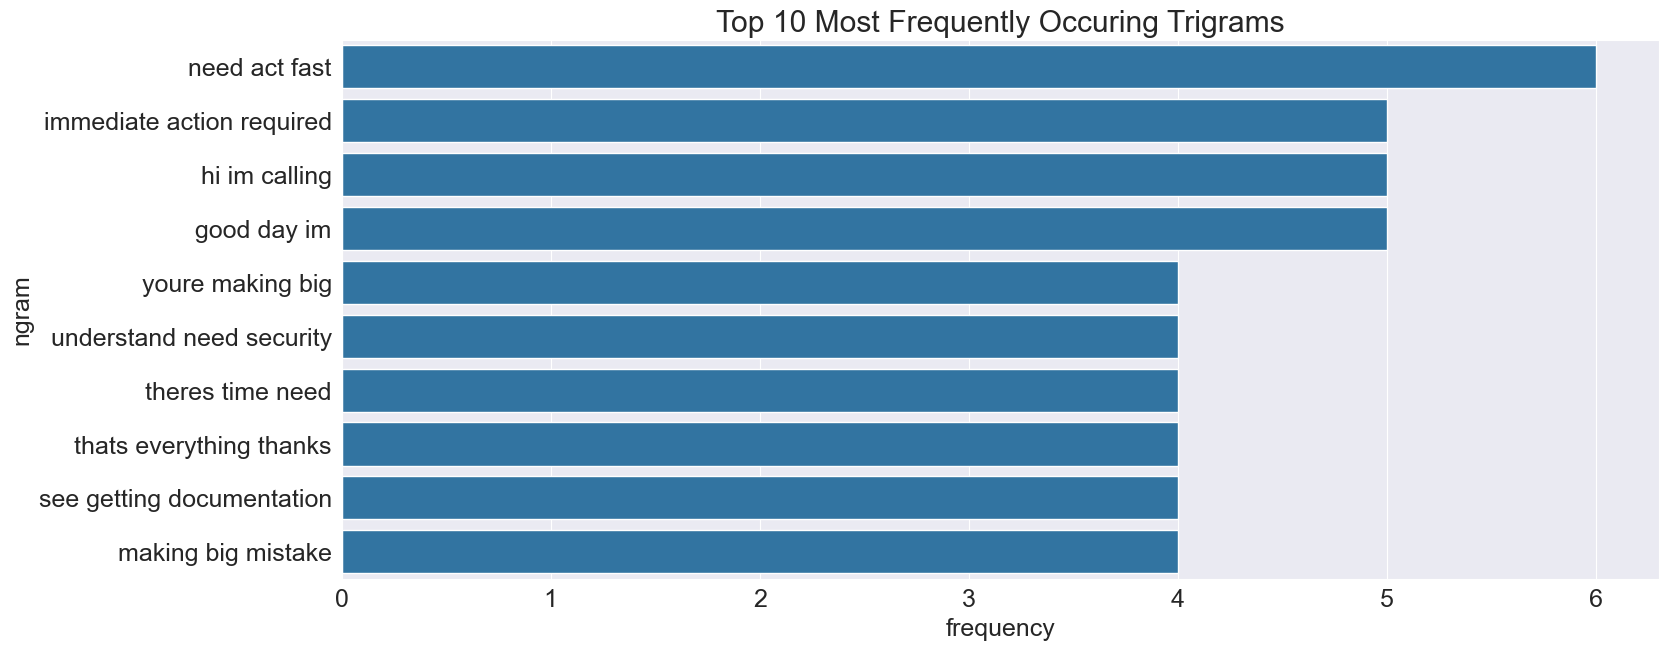

In [105]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['TEXT'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

Data Preparation

In [3]:
df = pd.read_csv('call_transcript_cleaned.csv')

# Convert 'TEXT' column to lowercase
df['TEXT'] = df['TEXT'].str.lower()
punctuation = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

# Apply remove_punctuation function to 'TEXT' column
df['TEXT'] = df['TEXT'].apply(remove_punctuation)

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply remove_stopwords function to 'TEXT' column
df['TEXT'] = df['TEXT'].apply(remove_stopwords)

# Intilize Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Apply 
df['Text_lemmatized'] = df['TEXT'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word , pos='v') for word in x.split()]))

# Head
df.head()


,CONVERSATION_ID,CONVERSATION_STEP,TEXT,CONTEXT,LABEL,FEATURES,CATEGORY,Text_lemmatized
0,6,2,hello name jamie im interested volunteering,Encourages the caller's interest,neutral,"welcoming, positive_tone",0,hello name jamie im interest volunteer
1,6,3,yes im really passionate environmental conserv...,Reinforces anyone can volunteer,neutral,inclusive,0,yes im really passionate environmental conserv...
2,6,4,great sign find information,Demonstrates flexibility,neutral,"helpful_tone, offers_options",0,great sign find information
3,6,5,could send link please email jamiegreenexamplecom,Fulfills caller's request quickly,neutral,prompt_action,0,could send link please email jamiegreenexamplecom
4,6,6,thank much help im really looking forward event,"Positive closure, offers future help",neutral,"supportive, positive_tone",0,thank much help im really look forward event


In [4]:
# Split the data into features and target
X = df['TEXT']  
y = df['CATEGORY']  

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

max_features = 5000 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 72 #Set to average length

# Padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

Model Architecture

In [4]:
embedding_vector_length = 32
model = tf.keras.Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=max_length))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
history = model.fit(X_train_padded, y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_test_padded, y_test))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.5202 - loss: 0.6892 - val_accuracy: 0.5926 - val_loss: 0.6787
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6602 - loss: 0.6540 - val_accuracy: 0.5926 - val_loss: 0.6835
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6790 - loss: 0.6264 - val_accuracy: 0.5926 - val_loss: 0.6627
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6578 - loss: 0.6233 - val_accuracy: 0.5926 - val_loss: 0.6205
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6870 - loss: 0.5684 - val_accuracy: 0.8148 - val_loss: 0.5408
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7851 - loss: 0.4693 - val_accuracy: 0.7870 - val_loss: 0.5028
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7925 - loss: 0.4309 - val_accuracy: 0.7407 - val_loss: 0.4765
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8101 - loss: 0.3404 - val_accuracy: 0.8056 - val_loss: 0.4355


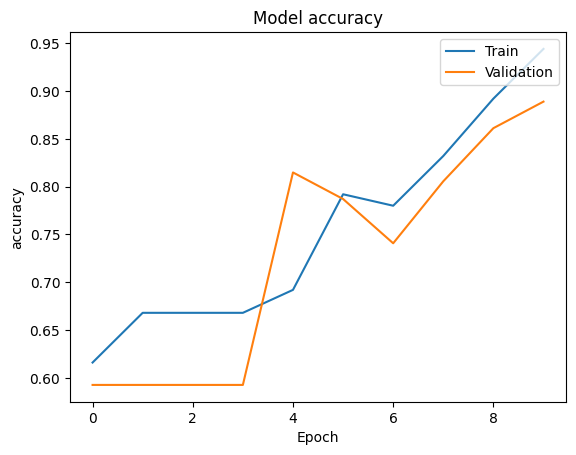

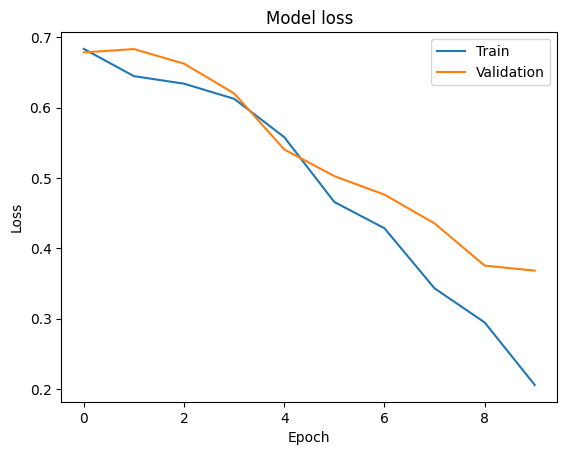

In [6]:
# Plotting the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]
cf_matrix =confusion_matrix(y_test, y_predict)
tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test,y_predict)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Precision: 87.14%
Recall: 95.31%
F1 Score: 91.04%


In [50]:
import random

# Define hyperparameter ranges
param_grid = {
    'embedding_dim': [32, 64, 128],
    'lstm_units': [32, 64, 128],
    'dense_units': [16, 32, 64],
    'dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [64, 128, 256],
    'epochs': [10, 20]
}

# Random search function
def random_search(param_grid, num_trials=10):
    best_model = None
    best_params = None
    best_score = 0
    results = []

    for i in range(num_trials):
        print(f"Trial {i+1}/{num_trials}")
        
        # Randomly sample hyperparameters
        params = {key: random.choice(values) for key, values in param_grid.items()}
        print("Testing parameters:", params)
        
        # Build and compile model
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(5000, params['embedding_dim'], input_length=max_length),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(params['lstm_units'], dropout=params['dropout_rate'])),
            tf.keras.layers.Dense(params['dense_units'], activation='relu'),
            tf.keras.layers.Dropout(params['dropout_rate']),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        # Train the model
        history = model.fit(X_train_padded, y_train,
                            batch_size=params['batch_size'],
                            epochs=params['epochs'],
                            validation_data=(X_test_padded, y_test),
                            verbose=0)  # Suppress output for cleaner results
        
        # Evaluate the model
        score = model.evaluate(X_test_padded, y_test, verbose=0)[1]  # Get validation accuracy
        
        results.append((params, score))
        print(f"Validation Accuracy: {score:.4f}\n")
        
        # Update best model and parameters
        if score > best_score:
            best_model = model
            best_params = params
            best_score = score

    print("Best Hyperparameters:", best_params)
    print(f"Best Validation Accuracy: {best_score:.4f}")
    
    return best_model, best_params, results

# Perform random search
best_model, best_params, results = random_search(param_grid, num_trials=10)

Trial 1/10
Testing parameters: {'embedding_dim': 64, 'lstm_units': 32, 'dense_units': 16, 'dropout_rate': 0.1, 'batch_size': 128, 'epochs': 10}


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation Accuracy: 0.5926

Trial 2/10
Testing parameters: {'embedding_dim': 128, 'lstm_units': 64, 'dense_units': 16, 'dropout_rate': 0.3, 'batch_size': 256, 'epochs': 20}
Validation Accuracy: 0.8333

Trial 3/10
Testing parameters: {'embedding_dim': 32, 'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.3, 'batch_size': 256, 'epochs': 20}
Validation Accuracy: 0.6852

Trial 4/10
Testing parameters: {'embedding_dim': 64, 'lstm_units': 32, 'dense_units': 16, 'dropout_rate': 0.2, 'batch_size': 128, 'epochs': 20}
Validation Accuracy: 0.8611

Trial 5/10
Testing parameters: {'embedding_dim': 128, 'lstm_units': 32, 'dense_units': 16, 'dropout_rate': 0.3, 'batch_size': 64, 'epochs': 20}
Validation Accuracy: 0.8981

Trial 6/10
Testing parameters: {'embedding_dim': 128, 'lstm_units': 32, 'dense_units': 32, 'dropout_rate': 0.3, 'batch_size': 128, 'epochs': 10}
Validation Accuracy: 0.8148

Trial 7/10
Testing parameters: {'embedding_dim': 32, 'lstm_units': 64, 'dense_units': 16, 'dropout_rate'

In [5]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=max_length))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss')
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test), callbacks=early_stopping)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.5141 - loss: 0.6870 - val_accuracy: 0.5926 - val_loss: 0.6671
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6831 - loss: 0.6237 - val_accuracy: 0.5926 - val_loss: 0.6638
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6806 - loss: 0.5978 - val_accuracy: 0.7037 - val_loss: 0.5803
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7242 - loss: 0.5605 - val_accuracy: 0.8426 - val_loss: 0.5089
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8217 - loss: 0.4539 - val_accuracy: 0.8241 - val_loss: 0.4383
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8774 - loss: 0.3701 - val_accuracy: 0.8704 - val_loss: 0.3670
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8914 - loss: 0.2956 - val_accuracy: 0.8611 - val_loss: 0.3397
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9424 - loss: 0.1780 - val_accuracy: 0.8981 - val_loss: 0.3619

In [7]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predict)))
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test,y_predict)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
Accuracy: 89.81%
Precision: 88.41%
Recall: 95.31%
F1 Score: 91.73%


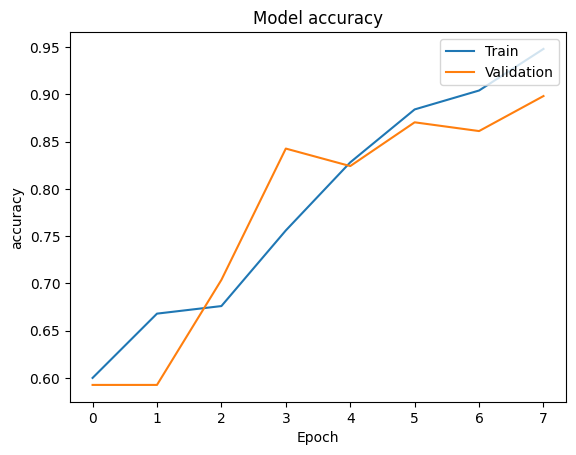

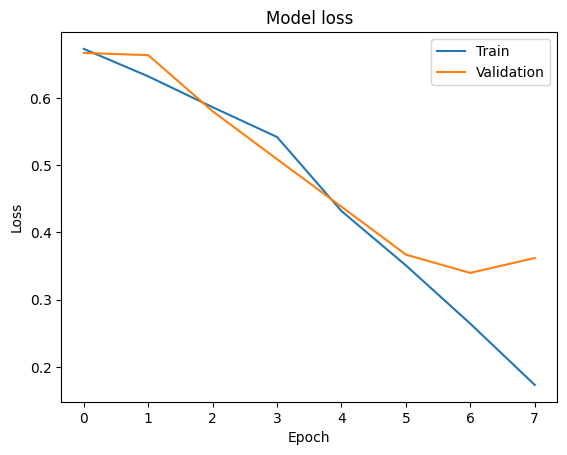

In [8]:
# Plotting the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

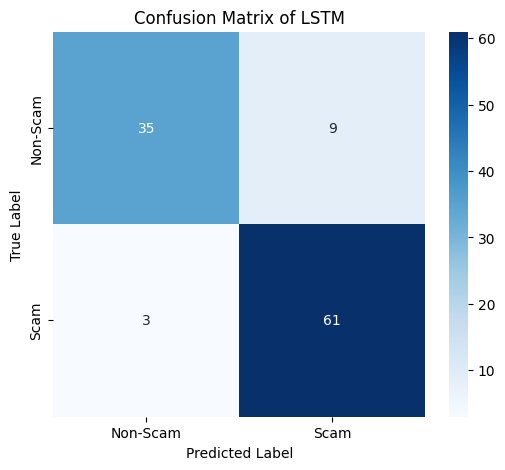

In [54]:
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Scam','Scam'], yticklabels=['Non-Scam','Scam'])
plt.title("Confusion Matrix of LSTM")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [9]:
# Create a feature-extraction model that outputs the last dense layer (before the final sigmoid)
feature_extractor = Sequential(model.layers[:-1])  # Remove the final layer
X_train_features = feature_extractor.predict(X_train_padded)
X_test_features = feature_extractor.predict(X_test_padded)

def train_and_evaluate_cv(classifier, X, y, y_pred):
    cv_scores = cross_val_score(classifier, X, y, cv=5)
    y_pred = cross_val_predict(classifier, X, y, cv=5)
    cv_score = np.mean(cv_scores)

    return cv_score, y_pred

# Train and evaluate Naive Bayes
gbm = GradientBoostingClassifier()
y_pred_gbm = []
cv_score_gbm, y_pred_gbm = train_and_evaluate_cv(gbm, X_train_features, y_train, y_pred_gbm)

# Train and evaluate Logistic Regression
logreg = LogisticRegression(max_iter=1000)
y_pred_logreg = []
cv_score_logreg, y_pred_logreg = train_and_evaluate_cv(logreg, X_train_features, y_train, y_pred_logreg)

# Train and evaluate Random Forest
rf = RandomForestClassifier(n_estimators=100)
y_pred_rf = []
cv_score_rf, y_pred_rf = train_and_evaluate_cv(rf, X_train_features, y_train, y_pred_rf)

# Train and evaluate SVM
svm = SVC(kernel='linear')
y_pred_svm = []
cv_score_svm, y_pred_svm = train_and_evaluate_cv(svm, X_train_features, y_train, y_pred_svm)

print("\nFor LSTM features with Gradient Boosting (CV):")
print(f"Accuracy: {100 * cv_score_gbm:.2f}%")
print("Precision: {:.2f}%".format(100 * precision_score(y_train, y_pred_gbm)))
print("Recall: {:.2f}%".format(100 * recall_score(y_train, y_pred_gbm)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_train,y_pred_gbm)))

print("\nFor LSTM features with SVM (CV):")
print(f"Accuracy: {100 * cv_score_svm:.2f}%")
print("Precision: {:.2f}%".format(100 * precision_score(y_train, y_pred_svm)))
print("Recall: {:.2f}%".format(100 * recall_score(y_train, y_pred_svm)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_train,y_pred_svm)))

print("\nFor LSTM features with Random Forest (CV):")
print(f"Random Forest Accuracy: {100 * cv_score_rf:.2f}%")
print("Precision: {:.2f}%".format(100 * precision_score(y_train, y_pred_rf)))
print("Recall: {:.2f}%".format(100 * recall_score(y_train, y_pred_rf)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_train,y_pred_rf)))

print("\nFor LSTM features with Logistic Regression (CV):")
print(f"Accuracy: {100 * cv_score_logreg:.2f}%")
print("Precision: {:.2f}%".format(100 * precision_score(y_train, y_pred_logreg)))
print("Recall: {:.2f}%".format(100 * recall_score(y_train, y_pred_logreg)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_train,y_pred_logreg)))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

For LSTM features with Gradient Boosting (CV):
Accuracy: 98.00%
Precision: 98.80%
Recall: 98.20%
F1 Score: 98.50%

For LSTM features with SVM (CV):
Accuracy: 98.40%
Precision: 99.39%
Recall: 98.20%
F1 Score: 98.80%

For LSTM features with Random Forest (CV):
Random Forest Accuracy: 98.00%
Precision: 98.79%
Recall: 97.60%
F1 Score: 98.19%

For LSTM features with Logistic Regression (CV):
Accuracy: 98.40%
Precision: 99.39%
Recall: 98.20%
F1 Score: 98.80%


Performance with test data for SVM + LSTM:
Test Accuracy: 89.81%
Test Precision: 88.41%
Test Recall: 95.31%
Test F1 Score: 91.73%


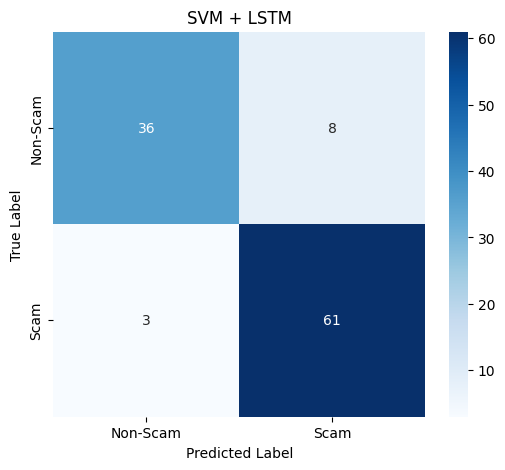

In [10]:
svm.fit(X_train_features, y_train)
y_pred_test = svm.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Performance with test data for SVM + LSTM:")
print(f"Test Accuracy: {100 * accuracy:.2f}%")
print(f"Test Precision: {100 * precision:.2f}%")
print(f"Test Recall: {100 * recall:.2f}%")
print(f"Test F1 Score: {100 * f1:.2f}%")

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Scam','Scam'], yticklabels=['Non-Scam','Scam'])
plt.title("SVM + LSTM")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Stacking

In [11]:
# SVM + Gradient Boosting + LSTM
stack_svm_gbm = StackingClassifier(classifiers =[gbm], meta_classifier = svm, use_probas = True, use_features_in_secondary = True)
y_pred_svm_gbm = []
cv_score_svm_gbm, y_pred_svm_gbm = train_and_evaluate_cv(stack_svm_gbm, X_train_features, y_train, y_pred_svm_gbm)

# SVM + Random Forest + LSTM
stack_svm_rf = StackingClassifier(classifiers =[rf], meta_classifier = svm, use_probas = True, use_features_in_secondary = True)
y_pred_svm_rf = []
cv_score_svm_rf, y_pred_svm_rf = train_and_evaluate_cv(stack_svm_rf, X_train_features, y_train, y_pred_svm_rf)

# SVM + Logistic Regression + LSTM
stack_svm_logreg = StackingClassifier(classifiers =[logreg], meta_classifier = svm, use_probas = True, use_features_in_secondary = True)
y_pred_svm_logreg = []
cv_score_svm_logreg, y_pred_svm_logreg = train_and_evaluate_cv(stack_svm_logreg, X_train_features, y_train, y_pred_svm_logreg)

print("\nSVM + Gradient Boosting + LSTM (CV):")
print(f"Accuracy: {100 * cv_score_svm_gbm:.2f}%")
print("Precision: {:.2f}%".format(100 * precision_score(y_train, y_pred_svm_gbm)))
print("Recall: {:.2f}%".format(100 * recall_score(y_train, y_pred_svm_gbm)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_train,y_pred_svm_gbm)))

print("\nSVM + Random Forest + LSTM (CV):")
print(f"Random Forest Accuracy: {100 * cv_score_svm_rf:.2f}%")
print("Precision: {:.2f}%".format(100 * precision_score(y_train, y_pred_svm_rf)))
print("Recall: {:.2f}%".format(100 * recall_score(y_train, y_pred_svm_rf)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_train,y_pred_svm_rf)))

print("\nSVM + Logistic Regression + LSTM (CV):")
print(f"Accuracy: {100 * cv_score_svm_logreg:.2f}%")
print("Precision: {:.2f}%".format(100 * precision_score(y_train, y_pred_svm_logreg)))
print("Recall: {:.2f}%".format(100 * recall_score(y_train, y_pred_svm_logreg)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_train,y_pred_svm_logreg)))


SVM + Gradient Boosting + LSTM (CV):
Accuracy: 98.00%
Precision: 98.80%
Recall: 98.20%
F1 Score: 98.50%

SVM + Random Forest + LSTM (CV):
Random Forest Accuracy: 98.00%
Precision: 98.80%
Recall: 98.20%
F1 Score: 98.50%

SVM + Logistic Regression + LSTM (CV):
Accuracy: 98.40%
Precision: 99.39%
Recall: 98.20%
F1 Score: 98.80%


Performance with test data for SVM + Logistic Regression + LSTM:
Test Accuracy: 89.81%
Test Precision: 88.41%
Test Recall: 95.31%
Test F1 Score: 91.73%


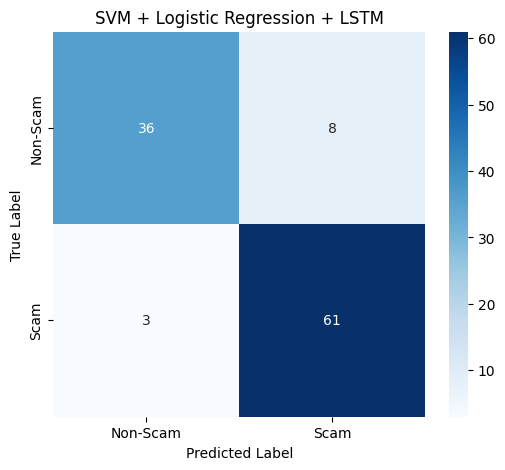

In [12]:
stack_svm_logreg.fit(X_train_features, y_train)
y_pred_test = stack_svm_logreg.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Performance with test data for SVM + Logistic Regression + LSTM:")
print(f"Test Accuracy: {100 * accuracy:.2f}%")
print(f"Test Precision: {100 * precision:.2f}%")
print(f"Test Recall: {100 * recall:.2f}%")
print(f"Test F1 Score: {100 * f1:.2f}%")

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Scam','Scam'], yticklabels=['Non-Scam','Scam'])
plt.title("SVM + Logistic Regression + LSTM")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Testing

In [16]:
feature_extractor = Sequential(model.layers[:-1])  # Remove the final layer
X_train_features = feature_extractor.predict(X_train_padded)
X_test_features = feature_extractor.predict(X_test_padded)

# The message to classify
message = input()

max_features = 5000 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

message_sequence = tokenizer.texts_to_sequences([message.lower()])  # Tokenize
message_padded = pad_sequences(message_sequence, maxlen=max_length)  # Pad to match LSTM input length

message_features = feature_extractor.predict(message_padded)

prediction = stack_svm_logreg.predict(message_features)

print(message)
if prediction[0] == 1:
    print("The message is classified as a scam.")
else:
    print("The message is classified as not a scam.")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Hello, this is your utility provider. We’re confirming your scheduled maintenance tomorrow.
The message is classified as not a scam.
